# Project: **Finding Lane Lines on the Road** 

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


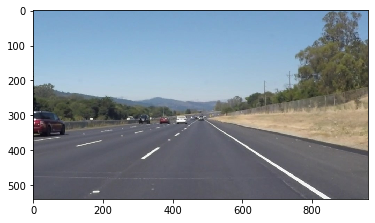

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Line detection pipeline

### Grayscale conversion

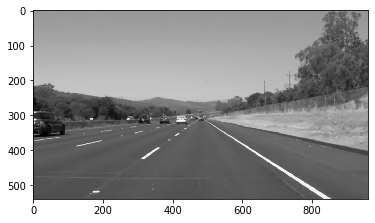

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')

### Gaussian smoothing

In [5]:
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

### Canny Edges

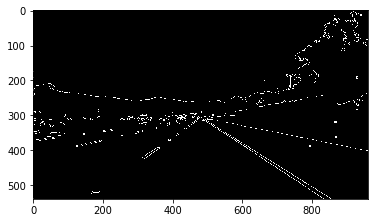

In [6]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')


### Mask

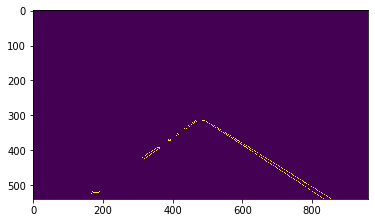

In [7]:
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 315), (490, 315), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges)

### Hough Transform

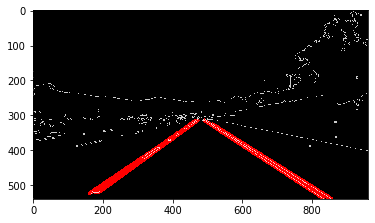

In [15]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 200 #minimum number of pixels making up a line
max_line_gap = 150    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

### Lines

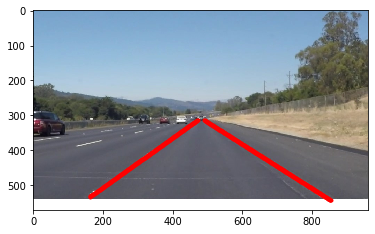

In [34]:
img = np.copy(image) # creating a blank to draw lines on
xL = []
yL = []
xR = []
yR = []

for line in lines:
        for x1,y1,x2,y2 in line:
            if ((y2-y1)/(x2-x1)) < 0:     
                xL += [x1, x2]
                yL += [y1, y2]
            else:
                xR += [x1, x2]
                yR += [y1, y2]

zL = np.polyfit(xL, yL,1)
mL, bL = zL

zR = np.polyfit(xR, yR,1)
mR, bR = zR

plt.imshow(img)
for i in range(min(xL), max(xL)):
    plt.plot(i, i * mL + bL, 'r.')
    
for i in range(min(xR), max(xR)):
    plt.plot(i, i * mR + bR, 'r.')
    

#line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
# Create a "color" binary image to combine with line image
#color_edgess = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
#lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
#plt.imshow(img_line)